## Evaluate a Trained MIDI Generator Model

This notebook demonstrates the evaluation of a trained MIDI generator model. The model is trained on a Simplified MIDI version of the GiantMIDIPiano dataset.

### 1. Import Libraries

In [1]:
import os
import warnings

os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore')

In [2]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    GPT2LMHeadModel,
    GPT2Config
)
from typing import List, Tuple
from tqdm.auto import tqdm
from midi_player import MIDIPlayer

In [3]:
from notation import MusicEvaluator
from text_to_midi import create_midi_file

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Load the Tokenizer

In [5]:
class BinnedQuadrupletMidiTokenizer:
    def __init__(self,
                 pitch_range: Tuple[int, int] = (0, 127),
                 volume_range: Tuple[int, int] = (0, 127),
                 duration_range: Tuple[int, int] = (0, 4000), # Example max
                 time_range: Tuple[int, int] = (0, 10000),  # Example max
                 duration_bins: int = 128, # Number of bins for duration
                 time_bins: int = 128      # Number of bins for time
                 ):

        self.pitch_range = pitch_range
        self.volume_range = volume_range
        # Store raw ranges and bin counts
        self.duration_info = {'range': duration_range, 'bins': duration_bins}
        self.time_info = {'range': time_range, 'bins': time_bins}

        self.vocab = {
            '<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '<note>': 4
        }
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.next_token_id = len(self.vocab)

        # Store prefixes
        self.prefixes = {
            'pitch': '<pitch_', 'volume': '<volume_',
            'duration': '<duration_bin_', 'time': '<time_bin_'
        }

        # --- Add tokens ---
        # Pitch and Volume (exact values)
        self._add_exact_value_tokens(pitch_range, self.prefixes['pitch'])
        self._add_exact_value_tokens(volume_range, self.prefixes['volume'])

        # Duration and Time (binned values)
        self.duration_boundaries = self._calculate_log_boundaries(duration_range, duration_bins)
        self.time_boundaries = self._calculate_log_boundaries(time_range, time_bins)
        self._add_bin_tokens(duration_bins, self.prefixes['duration'])
        self._add_bin_tokens(time_bins, self.prefixes['time'])

        self.vocab_size = len(self.vocab)
        self.pad_token_id = self.vocab['<pad>']
        self.bos_token_id = self.vocab['<s>']
        self.eos_token_id = self.vocab['</s>']
        self.unk_token_id = self.vocab['<unk>']
        self.note_token_id = self.vocab['<note>']

        # Precompile regex
        self.note_pattern = re.compile(r'p(\d+):v(\d+):d(\d+):t(\d+)')

    def _calculate_log_boundaries(self, value_range: Tuple[int, int], num_bins: int) -> np.ndarray:
        """Calculates logarithmic bin boundaries."""
        min_val, max_val = value_range
        if min_val < 0: min_val = 0 # Ensure non-negative for log
        # Add 1 before log, subtract 1 after to handle 0 correctly
        # Use logspace from log10(min_val+1) to log10(max_val+1)
        boundaries = np.logspace(
            np.log10(min_val + 1),
            np.log10(max_val + 1),
            num=num_bins + 1 # Need num_bins + 1 boundaries for num_bins bins
        ) - 1
        # Ensure the first boundary is exactly the minimum value if it was >= 0
        if min_val >= 0:
             boundaries[0] = min_val
        return boundaries

    def _add_exact_value_tokens(self, value_range: Tuple[int, int], prefix: str):
        """Adds tokens for each exact value in the range."""
        for i in range(value_range[0], value_range[1] + 1):
            token_name = f'{prefix}{i}>'
            self.vocab[token_name] = self.next_token_id
            self.inv_vocab[self.next_token_id] = token_name
            self.next_token_id += 1

    def _add_bin_tokens(self, num_bins: int, prefix: str):
        """Adds tokens for each bin index."""
        for i in range(num_bins):
            token_name = f'{prefix}{i}>'
            self.vocab[token_name] = self.next_token_id
            self.inv_vocab[self.next_token_id] = token_name
            self.next_token_id += 1

    def _get_bin_index(self, value: int, boundaries: np.ndarray) -> int:
        """Finds the appropriate bin index for a value."""
        # np.digitize returns the index of the bin (starting from 1)
        # boundaries[i-1] <= x < boundaries[i]
        bin_index = np.digitize(value, boundaries[1:], right=False) # Use boundaries[1:] because digitize checks < boundary
        # Ensure index is within bounds [0, num_bins-1]
        return min(bin_index, len(boundaries) - 2) # len(boundaries) - 2 is the max bin index

    def _get_value_token_id(self, value: int, value_range: Tuple[int, int], prefix: str) -> int:
        """Gets the token ID for an exact value."""
        if value_range[0] <= value <= value_range[1]:
            token_name = f'{prefix}{value}>'
            return self.vocab.get(token_name, self.unk_token_id)
        return self.unk_token_id

    def _get_bin_token_id(self, value: int, boundaries: np.ndarray, prefix: str) -> int:
        """Gets the token ID for a binned value."""
        min_val = boundaries[0]
        max_val = boundaries[-1]
        if min_val <= value <= max_val:
             bin_index = self._get_bin_index(value, boundaries)
             token_name = f'{prefix}{bin_index}>'
             return self.vocab.get(token_name, self.unk_token_id) # Should exist, but fallback
        return self.unk_token_id

    def tokenize(self, text: str) -> List[int]:
        tokens = [self.bos_token_id]
        note_blocks = text.strip().split(' ')
        for block in note_blocks:
            if not block: continue
            match = self.note_pattern.match(block)
            if match:
                try:
                    p_val = int(match.group(1))
                    v_val = int(match.group(2))
                    d_val = int(match.group(3))
                    t_val = int(match.group(4))

                    p_token_id = self._get_value_token_id(p_val, self.pitch_range, self.prefixes['pitch'])
                    v_token_id = self._get_value_token_id(v_val, self.volume_range, self.prefixes['volume'])
                    d_token_id = self._get_bin_token_id(d_val, self.duration_boundaries, self.prefixes['duration'])
                    t_token_id = self._get_bin_token_id(t_val, self.time_boundaries, self.prefixes['time'])

                    # Check if any tokenization resulted in UNK
                    if all(tid != self.unk_token_id for tid in [p_token_id, v_token_id, d_token_id, t_token_id]):
                        tokens.append(self.note_token_id)
                        tokens.append(p_token_id)
                        tokens.append(v_token_id)
                        tokens.append(d_token_id)
                        tokens.append(t_token_id)
                    else:
                        # Handle UNK during tokenization (e.g., value truly out of range)
                        tokens.extend([self.unk_token_id] * 5) # Or just one UNK? Depends.
                except (ValueError, IndexError):
                    tokens.extend([self.unk_token_id] * 5) # Malformed block
            else:
                 tokens.append(self.unk_token_id) # Non-matching block

        tokens.append(self.eos_token_id)
        return tokens

    def _get_value_from_exact_token(self, token_id: int, prefix: str) -> int | None:
        """Helper to extract value from exact value token."""
        token = self.inv_vocab.get(token_id)
        if token and token.startswith(prefix) and token.endswith('>'):
            try:
                return int(token[len(prefix):-1])
            except ValueError:
                return None
        return None

    def _get_approx_value_from_bin_token(self, token_id: int, prefix: str, boundaries: np.ndarray) -> str | None:
         """Helper to get an approximate representation from bin token."""
         token = self.inv_vocab.get(token_id)
         if token and token.startswith(prefix) and token.endswith('>'):
             try:
                 bin_index = int(token[len(prefix):-1])
                 if 0 <= bin_index < len(boundaries) - 1:
                     # Return a string representing the bin range or midpoint
                     lower_bound = boundaries[bin_index]
                     upper_bound = boundaries[bin_index + 1]
                     # Simple representation: midpoint rounded
                     midpoint = int(round((lower_bound + upper_bound) / 2))
                     # Or return range string: f"({int(lower_bound)}-{int(upper_bound)})"
                     return str(midpoint) # Return midpoint as string
                 else: return "<bin_idx_err>"
             except ValueError:
                 return "<bin_parse_err>"
         return None


    def decode(self, token_ids: List[int], skip_special_tokens: bool = True) -> str:
        notes_str = []
        i = 0
        while i < len(token_ids):
            token_id = token_ids[i]
            token = self.inv_vocab.get(token_id)

            special_tokens_to_handle = ['<s>', '</s>', '<pad>', '<unk>']

            if skip_special_tokens and token in special_tokens_to_handle:
                i += 1
                continue

            if not skip_special_tokens and token in special_tokens_to_handle:
                 notes_str.append(token)
                 i += 1
                 continue

            if token == '<note>':
                if i + 4 < len(token_ids): # Check for full quadruplet
                    p_token_id = token_ids[i+1]
                    v_token_id = token_ids[i+2]
                    d_token_id = token_ids[i+3]
                    t_token_id = token_ids[i+4]

                    p_val = self._get_value_from_exact_token(p_token_id, self.prefixes['pitch'])
                    v_val = self._get_value_from_exact_token(v_token_id, self.prefixes['volume'])
                    # Get approximate value string for duration and time
                    d_val_approx = self._get_approx_value_from_bin_token(d_token_id, self.prefixes['duration'], self.duration_boundaries)
                    t_val_approx = self._get_approx_value_from_bin_token(t_token_id, self.prefixes['time'], self.time_boundaries)


                    if all(v is not None for v in [p_val, v_val, d_val_approx, t_val_approx]):
                        notes_str.append(f"p{p_val}:v{v_val}:d{d_val_approx}:t{t_val_approx}")
                        i += 5 # Move past the <note> and its 4 value tokens
                    else:
                        # Malformed note sequence after <note>
                        if not skip_special_tokens: notes_str.append("<unk_note>")
                        i += 1 # Move past the <note> token only
                else:
                    # Not enough tokens after <note>
                    if not skip_special_tokens: notes_str.append("<partial_note>")
                    i += 1
            else:
                 # Unexpected token
                 if not skip_special_tokens: notes_str.append(token if token else "<unk_decode>")
                 i += 1

        return " ".join(notes_str)


In [6]:
def calculate_dt_ranges(dataset):
    """
    Calculates the minimum and maximum duration (d) and time (t) values
    found in the 'text' column of the dataset after preprocessing.
    """
    min_d, max_d = float('inf'), float('-inf')
    min_t, max_t = float('inf'), float('-inf')

    # Precompile regex for faster parsing
    note_pattern = re.compile(r'p(\d+):v(\d+):d(\d+):t(\d+)') # Slightly more robust

    print("Calculating duration (d) and time (t) ranges from dataset...")
    for example in tqdm(dataset):
        text = example['text']
        # --- Preprocessing logic (mirrors MidiDataset._preprocess_text) ---
        try:
            midi_sequence_start = text.find("[/INST]") + len("[/INST]")
            midi_sequence_end = text.find("</s>")
            if midi_sequence_end != -1:
                midi_sequence = text[midi_sequence_start:midi_sequence_end].strip()
            else:
                midi_sequence = text[midi_sequence_start:].strip()
        except:
            # Skip problematic examples during range calculation
            continue
        # --- End Preprocessing ---

        # Find all note matches in the preprocessed sequence
        # We can split by space first for potentially better performance on long strings
        note_blocks = midi_sequence.split(' ')
        for block in note_blocks:
            match = note_pattern.match(block) # Use match since we expect it at the start of the block
            if match:
                try:
                    # Extract d and t values as integers
                    d_val = int(match.group(3))
                    t_val = int(match.group(4))

                    # Update min/max
                    min_d = min(min_d, d_val)
                    max_d = max(max_d, d_val)
                    min_t = min(min_t, t_val)
                    max_t = max(max_t, t_val)
                except (ValueError, IndexError):
                    continue

    # Handle cases where no valid values were found
    if min_d == float('inf'): min_d = 0
    if max_d == float('-inf'): max_d = 2000 # Sensible default max if none found
    if min_t == float('inf'): min_t = 0
    if max_t == float('-inf'): max_t = 2000 # Sensible default max if none found

    print("Calculation complete.")
    # Ensure min is not greater than max if only one value was found
    if min_d > max_d: max_d = min_d
    if min_t > max_t: max_t = min_t

    return (min_d, max_d), (min_t, max_t)

In [7]:
def filter_by_max_t(example, max_t_threshold):
    """
    Checks if all 't' values in a single dataset example are <= max_t_threshold.
    Returns True to keep the example, False to discard it.
    """
    text = example['text']
    # --- Preprocessing logic ---
    try:
        midi_sequence_start = text.find("[/INST]") + len("[/INST]")
        midi_sequence_end = text.find("</s>")
        if midi_sequence_end != -1: midi_sequence = text[midi_sequence_start:midi_sequence_end].strip()
        else: midi_sequence = text[midi_sequence_start:].strip()
    except: return True # Keep examples where preprocessing fails
    # --- End Preprocessing ---

    t_pattern = re.compile(r':t(\d+)')
    matches = t_pattern.finditer(midi_sequence)
    try:
        for match in matches:
            t_val = int(match.group(1))
            if t_val > max_t_threshold: return False # Discard example
    except ValueError: return True # Keep examples with parsing errors
    except Exception: return True # Keep on other unexpected errors
    return True # Keep if all checks pass

In [8]:
dataset_name = "fegounna/GMP_4K"
raw_dataset_split = "train[:40000]" # Adjust size as needed
dataset = load_dataset(dataset_name, split=raw_dataset_split)
MAX_T_THRESHOLD = 10000

# --- Load Raw Dataset ---
print(f"Loading raw dataset split: {raw_dataset_split}...")
raw_dataset = load_dataset(dataset_name, split=raw_dataset_split)
print(f"Original dataset size: {len(raw_dataset)}")

# --- Filter Dataset ---
print(f"Filtering dataset with max_t_threshold = {MAX_T_THRESHOLD}...")
filtered_dataset = raw_dataset.filter(
    lambda example: filter_by_max_t(example, MAX_T_THRESHOLD)
)
print(f"Filtered dataset size: {len(filtered_dataset)}")

# --- Calculate Ranges on FILTERED data ---
print("Calculating ranges on filtered dataset...")
duration_range, pause_range = calculate_dt_ranges(filtered_dataset) # Use filtered_dataset
print(f"Calculated Duration (d) Range: {duration_range}")
print(f"Calculated Pause (t) Range: {pause_range}") # This range should now respect the threshold


# Instantiate BINNED Tokenizer using calculated ranges and desired bins
DURATION_BINS = 2048 # Control vocab size vs precision trade-off
TIME_BINS = 4096   # Control vocab size vs precision trade-off

tokenizer = BinnedQuadrupletMidiTokenizer(
    duration_range=duration_range,
    time_range=pause_range,
    duration_bins=DURATION_BINS,
    time_bins=TIME_BINS
)

Loading raw dataset split: train[:40000]...
Original dataset size: 40000
Filtering dataset with max_t_threshold = 10000...
Filtered dataset size: 39839
Calculating ranges on filtered dataset...
Calculating duration (d) and time (t) ranges from dataset...


  0%|          | 0/39839 [00:00<?, ?it/s]

Calculation complete.
Calculated Duration (d) Range: (0, 4613)
Calculated Pause (t) Range: (0, 9993)


### 3. Load a Trained Model

In [9]:
# We create a small GPT-2 like model configuration and instantiate the model.

config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_embd=384,      # Embedding dimension
    n_head=6,        # Number of attention heads
    n_layer=6,       # Number of layers
    n_positions=512, # Max sequence length - adjust if needed
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

model = GPT2LMHeadModel(config)
print(f"Model parameters: {model.num_parameters()}")


Model parameters: 13303680


In [10]:
output_dir = "./models"
model_name = "model_3_epochs"

model = model.from_pretrained(f"{output_dir}/{model_name}")
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(6405, 384)
    (wpe): Embedding(512, 384)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=1152, nx=384)
          (c_proj): Conv1D(nf=384, nx=384)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1536, nx=384)
          (c_proj): Conv1D(nf=384, nx=1536)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=384, out_features=6405, bias=False)
)

### 3. Generate MIDI Sequences

In [ ]:
def generate_midi_sequence_nucleus(
    prompt_text: str = "",
    max_new_tokens: int = 256, # Renamed for clarity: generates this many NEW tokens
    top_p: float = 0.9,        # Nucleus sampling probability threshold (e.g., 0.85, 0.9, 0.95)
    temperature: float = 0.8,  # Optional: slight temperature can smooth probabilities before top_p
    device = None
):
    """Generates MIDI sequence using nucleus sampling."""

    if device is None:
      device = model.device # Use the model's device by default

    input_tokens = tokenizer.tokenize(prompt_text)
    input_tensor = torch.tensor([input_tokens]).to(device)
    input_length = input_tensor.shape[1] # Length of the prompt tokens

    # Calculate the total max_length for the generate function
    total_max_length = input_length + max_new_tokens

    generated_token_ids = model.generate(
        input_tensor,
        max_length=total_max_length,    # Total desired sequence length
        do_sample=True,                 # MUST be True for sampling strategies
        top_p=top_p,                    # Enable nucleus sampling
        temperature=temperature,        # Control randomness (1.0 = no change)
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # Extract only the generated tokens (excluding the prompt)
    generated_part_ids = generated_token_ids[0, input_length:]

    # Decode the generated part
    generated_sequence = tokenizer.decode(generated_part_ids.tolist(), skip_special_tokens=True) # Skip special tokens for cleaner output

    return generated_sequence.strip() # Remove leading/trailing whitespace

# --- Example Usage ---

prompt = "" # Start generation from scratch
# Let's generate approximately 510 *new* tokens
# Note: Tokenizer adds BOS/EOS, so actual number might vary slightly depending on tokenizer implementation
max_new_tokens_to_generate = 510

generated_midi = generate_midi_sequence_nucleus(
    prompt_text=prompt,
    max_new_tokens=max_new_tokens_to_generate,
    top_p=0.95,       # Common value for nucleus sampling
    temperature=0.9  # Slightly reduced temperature often works well with top_p
)

print(f"\n--- Generated MIDI Sequence ---")
print(generated_midi)
print(f"--- End of Sequence ---")


--- Generated MIDI Sequence ---
p56:v63:d47:t1 p64:v52:d52:t0 p68:v61:d46:t1 p64:v56:d42:t114 p64:v69:d44:t5 p68:v81:d34:t0 p68:v69:d40:t1 p64:v74:d50:t7 p76:v80:d5:t0 p71:v74:d5:t8 p64:v57:d24:t105 p64:v76:d32:t4 p71:v73:d30:t0 p68:v70:d32:t6 p64:v71:d59:t2 p59:v63:d35:t113 p68:v81:d25:t1 p64:v74:d23:t1 p56:v78:d25:t2 p64:v77:d26:t1 p76:v82:d27:t0 p64:v72:d28:t1 p68:v70:d50:t5 p64:v66:d37:t107 p63:v86:d34:t1 p59:v83:d32:t1 p64:v76:d28:t1 p68:v74:d28:t6 p64:v65:d49:t95 p68:v73:d41:t0 p64:v66:d32:t1 p59:v76:d27:t5 p56:v65:d42:t2 p64:v69:d26:t1 p59:v61:d49:t101 p64:v66:d35:t4 p68:v76:d24:t2 p64:v63:d51:t4 p59:v72:d38:t0 p59:v59:d43:t0 p64:v58:d45:t0 p56:v60:d40:t1 p64:v68:d42:t1 p59:v67:d45:t99 p68:v73:d37:t0 p64:v70:d36:t1 p59:v65:d41:t2 p68:v62:d49:t6 p64:v61:d34:t108 p68:v80:d38:t1 p64:v70:d30:t2 p59:v62:d33:t0 p68:v60:d38:t3 p64:v56:d29:t109 p68:v66:d43:t1 p64:v62:d28:t1 p59:v52:d58:t0 p64:v53:d49:t2 p59:v55:d44:t1 p68:v63:d42:t1 p59:v59:d41:t105 p68:v76:d33:t3 p59:v69:d33:t1 p56:v6

In [12]:
def generate_midi_sequence_and_file(
    prompt_text: str = "",
    max_new_tokens: int = 256, # Renamed for clarity: generates this many NEW tokens
    top_p: float = 0.9,        # Nucleus sampling probability threshold (e.g., 0.85, 0.9, 0.95)
    temperature: float = 0.8,  # Optional: slight temperature can smooth probabilities before top_p
    device = None,
    output_dir: str = "./outputs",
    output_filename: str = "generated_midi"
):
    """Generates MIDI sequence using nucleus sampling and saves to a MIDI file."""

    generated_midi = generate_midi_sequence_nucleus(
        prompt_text=prompt_text,
        max_new_tokens=max_new_tokens,
        top_p=top_p,
        temperature=temperature,
        device=device
    )
    while generated_midi == "":
        generated_midi = generate_midi_sequence_nucleus(
            prompt_text=prompt_text,
            max_new_tokens=max_new_tokens,
            top_p=top_p,
            temperature=temperature,
            device=device
        )
        
    generated_midi += " "

    # Save the generated MIDI sequence to a file
    os.makedirs(output_dir, exist_ok=True)
    output_path_simplified = os.path.join(output_dir, f"{output_filename}.txt")
    output_path = os.path.join(output_dir, f"{output_filename}.mid")
    
    # Save the simplified text representation
    with open(output_path_simplified, "w") as text_file:
        text_file.write(generated_midi)
        
    header = ["0, 0, Header,1, 2, 384\n", "1, 0, Start_track\n", "1, 0, Tempo, 500000\n", "1, 0, Time_signature, 4, 2, 24, 8\n", "1, 1, End_track\n", "2, 0, Start_track\n"]
    # Convert the simplified text representation to a MIDI file
    create_midi_file(output_path_simplified, output_path, header=header)
    
    return generated_midi

### 4. Evaluate the Generated MIDI Sequences Qualitatively

In [13]:
# --- Example Usage ---
output_dir = "./outputs"
output_filename = "generated_midi"

# Generate MIDI sequence and save to file
generated_midi_file = generate_midi_sequence_and_file(
    prompt_text=prompt,
    max_new_tokens=max_new_tokens_to_generate,
    top_p=0.95,       # Common value for nucleus sampling
    temperature=0.9,  # Slightly reduced temperature often works well with top_p
    output_dir=output_dir,
    output_filename=output_filename
)
# Play the generated MIDI file
MIDIPlayer(f"{output_dir}/{output_filename}.mid", 400, title='Generated MIDI')

### 5. Evaluate the Generated MIDI Sequences Quantitatively

In [14]:
def evaluate_simplified_midi_file(simplified_midi_path: str, alpha: float = 1.0, beta: float = 1.0, t_ref: int = 480, verbose: bool = True):
    """Evaluates a simplified MIDI file using the MusicEvaluator class."""
    evaluator = MusicEvaluator(alpha=alpha, beta=beta, t_ref=t_ref)
    with open(simplified_midi_path, "r") as f:
        simplified_midi = f.read()
    result = evaluator.evaluate(simplified_midi)
    if verbose:
        print(f"Music Evaluation Results:")
        print(f"Total Score: {result['total_score']}/20")
        print(f"Harmonic Score: {result['harmonic_score']}/10")
        print(f"Duration Score: {result['duration_score']}/5")
        print(f"Time Score: {result['time_score']}/5")
    
    return result

In [15]:
# --- Example Usage ---
output_dir = "./outputs"
output_filename = "generated_midi"

# Generate MIDI sequence and save to file
generated_midi_file = generate_midi_sequence_and_file(
    prompt_text=prompt,
    max_new_tokens=max_new_tokens_to_generate,
    top_p=0.95,       # Common value for nucleus sampling
    temperature=0.9,  # Slightly reduced temperature often works well with top_p
    output_dir=output_dir,
    output_filename=output_filename
)
print("")
results = evaluate_simplified_midi_file(os.path.join(output_dir, f"{output_filename}.txt"))


Music Evaluation Results:
Total Score: 18.19/20
Harmonic Score: 9.41/10
Duration Score: 4.38/5
Time Score: 4.4/5


### 6. Do a full scale evaluation of the model

In [46]:
NUMBER_GENERATIONS = 100
PLAY_RESULTS = False
top_p = 0.95
temperature = 0.8

# Generate multiple MIDI sequences and evaluate them
generated_midi_files = []
evaluation_results = []

for i in tqdm(range(NUMBER_GENERATIONS)):
    output_filename = f"generated_midi_{i+1}"
    generated_midi_file = generate_midi_sequence_and_file(
        prompt_text=prompt,
        max_new_tokens=max_new_tokens_to_generate,
        top_p=top_p,       # Common value for nucleus sampling
        temperature=temperature,  # Slightly reduced temperature often works well with top_p
        output_dir=output_dir,
        output_filename=output_filename
    )
    results = evaluate_simplified_midi_file(os.path.join(output_dir, f"{output_filename}.txt"), verbose=False)
    generated_midi_files.append(generated_midi_file)
    evaluation_results.append(results)
    
# Calculate average scores
total_scores = [result["total_score"] for result in evaluation_results]
harmonic_scores = [result["harmonic_score"] for result in evaluation_results]
duration_scores = [result["duration_score"] for result in evaluation_results]
time_scores = [result["time_score"] for result in evaluation_results]

average_total_score = sum(total_scores) / len(total_scores)
average_harmonic_score = sum(harmonic_scores) / len(harmonic_scores)
average_duration_score = sum(duration_scores) / len(duration_scores)
average_time_score = sum(time_scores) / len(time_scores)

print(f"\n--- Average Evaluation Scores ---")
print(f"Total Score: {average_total_score:.2f}/20")
print(f"Harmonic Score: {average_harmonic_score:.2f}/10")
print(f"Duration Score: {average_duration_score:.2f}/5")
print(f"Time Score: {average_time_score:.2f}/5")

  0%|          | 0/100 [00:00<?, ?it/s]


--- Average Evaluation Scores ---
Total Score: 17.99/20
Harmonic Score: 9.62/10
Duration Score: 3.84/5
Time Score: 4.53/5


Plot the box plot of the distribution of the metrics for the generated MIDI sequences.

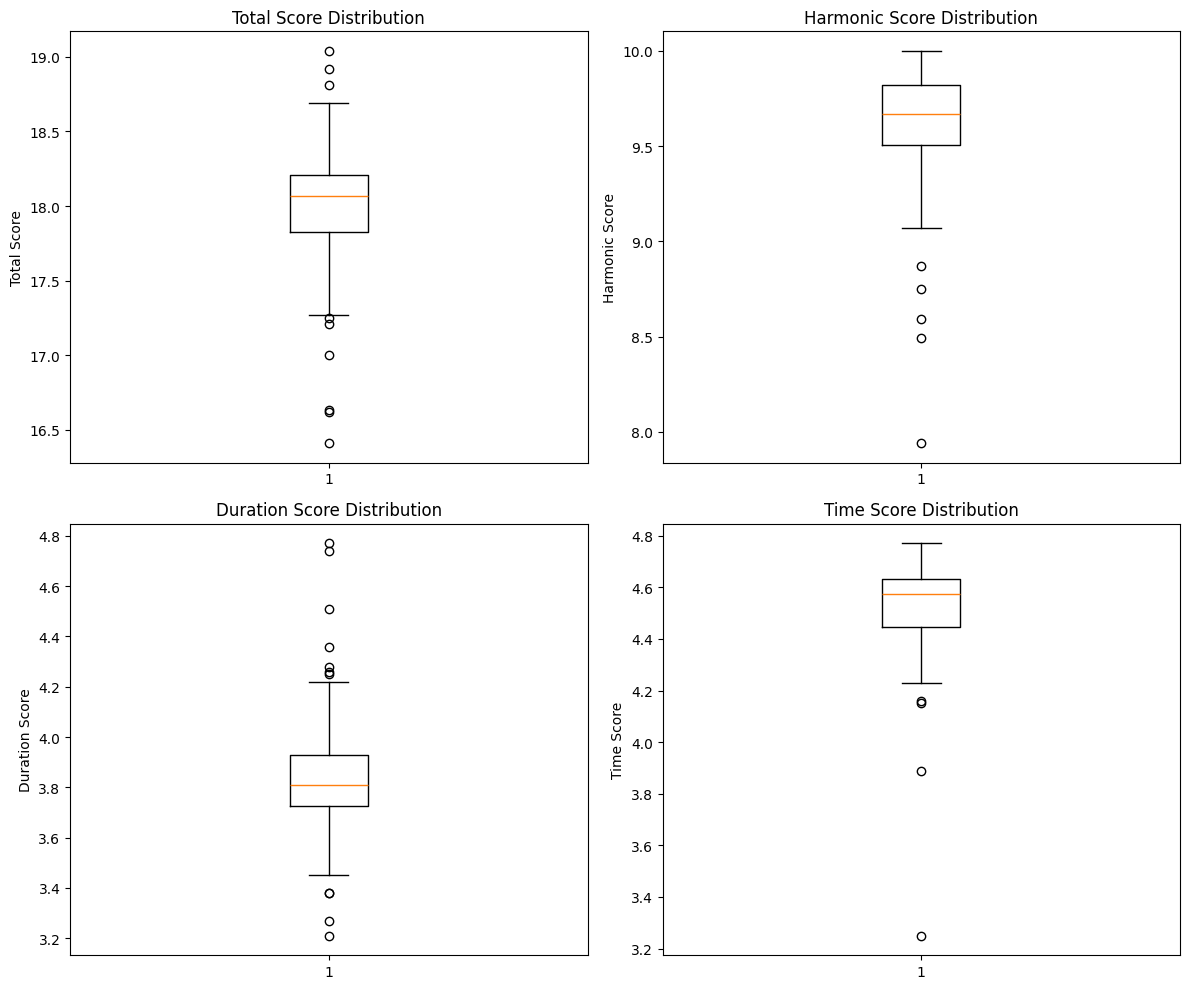

In [48]:
# Plot the boxplots of all scores
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()

ax[0].boxplot(total_scores)
ax[0].set_title("Total Score Distribution")
ax[0].set_ylabel("Total Score")

ax[1].boxplot(harmonic_scores)
ax[1].set_title("Harmonic Score Distribution")
ax[1].set_ylabel("Harmonic Score")

ax[2].boxplot(duration_scores)
ax[2].set_title("Duration Score Distribution")
ax[2].set_ylabel("Duration Score")

ax[3].boxplot(time_scores)
ax[3].set_title("Time Score Distribution")
ax[3].set_ylabel("Time Score")

plt.tight_layout()
plt.show()

Order the results by the metrics and show the best and worst MIDI sequences.

In [74]:
sorted_results = sorted(enumerate(evaluation_results), key=lambda x: x[1]["total_score"], reverse=True)

In [102]:
best_index, best_result = sorted_results[0]
print(f"Best MIDI Generation (Index {best_index + 1}):")
print(f"Total Score: {best_result['total_score']}/20")
print(f"Harmonic Score: {best_result['harmonic_score']}/10")
print(f"Duration Score: {best_result['duration_score']}/5")
print(f"Time Score: {best_result['time_score']}/5")
MIDIPlayer(f"{output_dir}/generated_midi_{best_index}.mid", 400, title='Best MIDI')

Best MIDI Generation (Index 79):
Total Score: 19.04/20
Harmonic Score: 9.62/10
Duration Score: 4.74/5
Time Score: 4.69/5


In [103]:
worst_index, worst_result = sorted_results[-1]
print(f"Worst MIDI Generation (Index {worst_index + 1}):")
print(f"Total Score: {worst_result['total_score']}/20")
print(f"Harmonic Score: {worst_result['harmonic_score']}/10")
print(f"Duration Score: {worst_result['duration_score']}/5")
print(f"Time Score: {worst_result['time_score']}/5")
MIDIPlayer(f"{output_dir}/generated_midi_{worst_index}.mid", 400, title='Worst MIDI')

Worst MIDI Generation (Index 23):
Total Score: 16.41/20
Harmonic Score: 9.07/10
Duration Score: 3.45/5
Time Score: 3.89/5
